# Setting up

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

# from preprocessing import load_wisconsin_prepr

# Interpretability measures
from interpretability import PDP

In [23]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('balanced_accuracy'), cv=StratifiedKFold())
    clf.fit(X_train, y_train)

    return clf

# Calculates the per-class accuracy given predicted and true output labels.
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

# Prints a summary of performance metrics given predicted and true output labels.
def print_metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    print(f'F1 = {f1}')
    print(f'Accuracy = {acc}')
    print(f'\tclass 0: {acc0}')
    print(f'\tclass 1: {acc1}')

def classify(output: np.ndarray):
    return (output > 0.5).astype(int)

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    if model_name == "neural network":
        y_pred = np.reshape(y_pred, len(y_test))
        y_pred = classify(y_pred)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy ({}) = {}".format(model_name, bal_acc))
    print_metrics(y_pred, y_test)

In [50]:
X, y, feature_names = load_wisconsin_prepr()
seed = 3011

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Training models

## Scikit-learn models

In [52]:
model_names = [
    "k-nearest neighbors", 
    "decision tree classifier",
    "support vector classifier",
    ]

parameters = {
    "k-nearest neighbors": {'n_neighbors': np.arange(1, 20), 'weights': ('uniform', 'distance')}, # 'n_neighbors': np.arange(1, 364)
    "decision tree classifier": {'criterion': ('gini', 'entropy'), 'min_samples_split': np.arange(2, 20)}, # 'min_samples_split': np.arange(2, 364)
    "support vector classifier": {'C': np.geomspace(0.01, 100, 41)}
    }

models_init = {
    "k-nearest neighbors": KNeighborsClassifier(),
    "decision tree classifier": DecisionTreeClassifier(random_state=seed),
    "support vector classifier": SVC(kernel="linear")
    }

models = dict()

for model_name in model_names:
    clf = find_best_model(models_init[model_name], parameters[model_name], X_train, y_train)
    models[model_name] = clf.best_estimator_

## Neural network

In [53]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=seed, stratify=y_)

In [ ]:
# Initialise neural network
BATCH_SIZE=64
INPUT_SIZE= X_train.shape[1]

set_seed(seed)

model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(5, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics='binary_accuracy')

n_epochs = 1629
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val, y_val)) # validation_split=0.2)

models["neural network"] = model

## Errors

In [55]:
for model_name in models.keys():
    print_errors(models[model_name], model_name, X_test, y_test)

Balanced accuracy (k-nearest neighbors) = 0.9692460317460317
F1 = 0.9793103448275863
Accuracy = 0.9736842105263158
	class 0: 0.9523809523809523
	class 1: 0.9861111111111112
Balanced accuracy (decision tree classifier) = 0.9295634920634921
F1 = 0.943661971830986
Accuracy = 0.9298245614035088
	class 0: 0.9285714285714286
	class 1: 0.9305555555555556
Balanced accuracy (support vector classifier) = 0.9404761904761905
F1 = 0.9664429530201343
Accuracy = 0.956140350877193
	class 0: 0.8809523809523809
	class 1: 1.0
Balanced accuracy (neural network) = 0.9761904761904762
F1 = 0.9863013698630138
Accuracy = 0.9824561403508771
	class 0: 0.9523809523809523
	class 1: 1.0


# Intrinsic interpretability

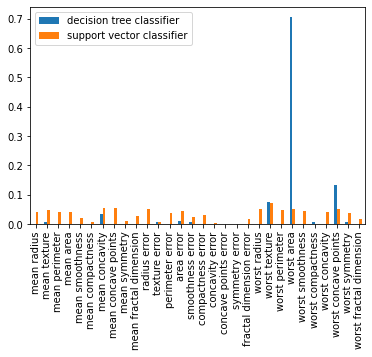

In [57]:
dtr_feat_imps = models["decision tree classifier"].feature_importances_

svc_coefs = models["support vector classifier"].coef_[0]
svc_feat_imps = np.abs(svc_coefs) / np.sum(np.abs(svc_coefs))

feat_imps = pd.DataFrame({"decision tree classifier": dtr_feat_imps, "support vector classifier": svc_feat_imps}, index=feature_names)
feat_imps.plot.bar()

# Partial dependence plot

k-nearest neighbors


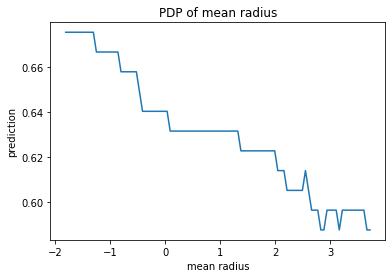

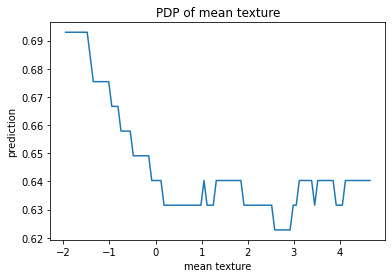

decision tree classifier


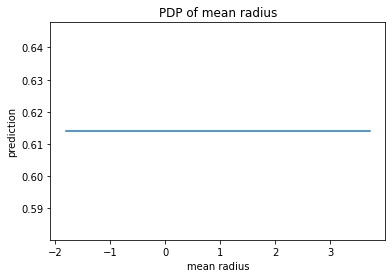

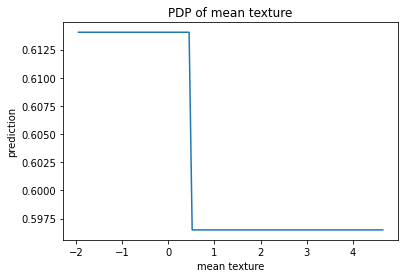

support vector classifier


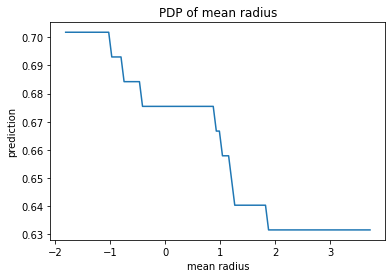

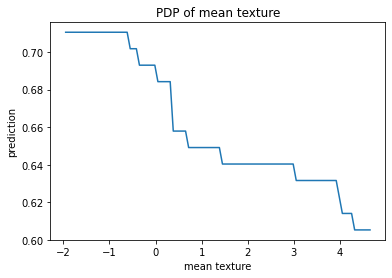

neural network


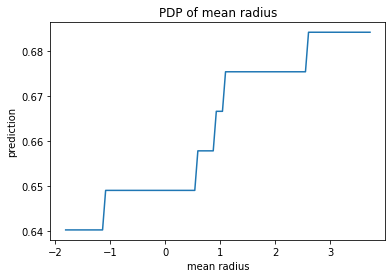

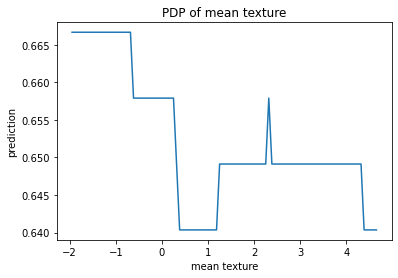

In [58]:
for model_name in models.keys():
    model = models[model_name]
    print(model_name)

    for i in range(2): # range(X_test.shape[1]):
        PDP(i, feature_names[i], model, X_test, y_test, categorical=False)
        plt.show()
        plt.close()

# SHAP

## Instance-based interpretability

In [104]:
explainers = dict()

In [ ]:
model_name = "neural network"
model = models[model_name]

def nn_predict(X):
  y_pred = model.predict(X)
  y_pred = np.reshape(y_pred, X.shape[0])
  return classify(np.array(y_pred))

explainers[model_name] = shap.KernelExplainer(nn_predict, X_train)

In [ ]:
model_name = "support vector classifier"
model = models[model_name]

explainers[model_name] = shap.KernelExplainer(model.predict, X_train)

In [ ]:
model_name = "k-nearest neighbors"
model = models[model_name]

explainers[model_name] = shap.KernelExplainer(model.predict, X_train)

In [135]:
model_name = "decision tree classifier"
model = models[model_name]

explainers[model_name] = shap.TreeExplainer(model)

In [ ]:
idx = 4
model_name = "k-nearest neighbors"

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = explainers[model_name]
shap_test = explainer.shap_values(X_test_df.iloc[idx])

# PLOT SHAPLEY VALUES IN NORMAL WAY

shap.initjs()
shap.force_plot(explainer.expected_value, shap_test, X_test_df.iloc[idx])
# shap.force_plot(explainer.expected_value[1], shap_test[1], X_test_df.iloc[idx]) # for decision trees

## Global interpretation

In [167]:
shapley_feat_imps = pd.DataFrame()
shapley_feat_imps

X_test_df = pd.DataFrame(X_test, columns=feature_names)

In [ ]:
for model_name in models.keys():
    explainer = explainers[model_name]
    shap_values = explainer.shap_values(X_test_df.iloc[:5])
    if model_name == "decision tree classifier":
        shap_values = shap_values[1]
    print(shap_values)
    print(shap_values.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [46]:
feat_imps = np.mean(np.abs(shap_test),axis=0)
feat_imps /= np.sum(feat_imps)
sort_idx = np.argsort(feat_imps)[::-1]

df = pd.DataFrame({'Shapley': feat_imps[sort_idx], 'Intrinsic': (np.abs(model.coef_[0]) / np.sum(np.abs(model.coef_[0])))[sort_idx]}, index=feature_names[sort_idx])
df.plot.bar()

AttributeError: ignored

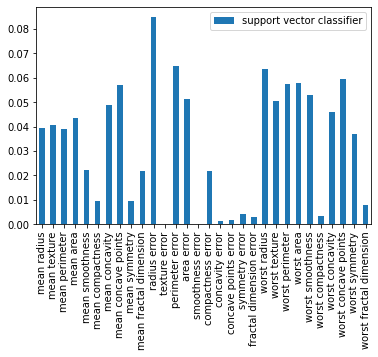

In [17]:
shapley_feat_imps = np.mean(np.abs(shap_test),axis=0)
shapley_feat_imps /= np.sum(shapley_feat_imps)

shapley_feat_imps = pd.DataFrame({"support vector classifier": shapley_feat_imps}, index=feature_names)
shapley_feat_imps.plot.bar()

# Prutsen

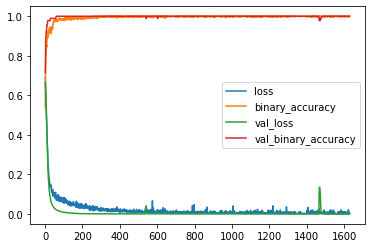

1418
(array([1418]),)


In [61]:
# Beste aantal epochs zoeken

for key in history.history.keys():
    plt.plot(np.arange(1, n_epochs+1), history.history[key], label=key)
plt.legend()
plt.show()

print(np.argmin(history.history['val_loss']))
print(np.where(history.history['val_loss'] == np.min(history.history['val_loss'])))